In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from numpy import load
from moepy import lowess
from scipy.stats import linregress
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import spearmanr

In [2]:
#load replicate variant count data
df_1 = pd.read_csv("RNU42brL41.txt", sep="\t")
df_2 = pd.read_csv("RNU42brL42.txt", sep="\t")

In [3]:
# filter data to both edits (200-X-A is introduced bioinformatically as the pipeline takes two blocking mutation into account for variant counting)
df_1 = df_1[df_1['edit_string'].str.contains('22-X-C') & df_1['edit_string'].str.contains('200-X-A')]
df_2 = df_2[df_2['edit_string'].str.contains('22-X-C') & df_2['edit_string'].str.contains('200-X-A')]

In [4]:
# Step 1: Filter out rows with more than 2 commas in 'edit_string' (sequencing errors and other)
df_1 = df_1[df_1['edit_string'].str.count(',') == 2]
df_2 = df_2[df_2['edit_string'].str.count(',') == 2]

In [5]:
# Step 2: Extract the middle string between the two commas for formatting
df_1['Entry'] = df_1['edit_string'].apply(lambda x: x.split(',')[1])
df_2['Entry'] = df_2['edit_string'].apply(lambda x: x.split(',')[1])

In [6]:
# Step 3: Extract the number from the middle string
df_1['Pos'] = df_1['Entry'].apply(lambda x: x.split('-')[0])
df_2['Pos'] = df_2['Entry'].apply(lambda x: x.split('-')[0])

In [7]:
#Calculate log2 post_pre ratios 
df_1['Log2_post_pre_ratio'] = np.log2(df_1['post_pre_ratio'].astype('float'))
df_2['Log2_post_pre_ratio'] = np.log2(df_2['post_pre_ratio'].astype('float'))
df_1['Log2_post_lib_ratio'] = np.log2(df_1['post_lib_ratio'].astype('float'))
df_2['Log2_post_lib_ratio'] = np.log2(df_2['post_lib_ratio'].astype('float'))

#Log2 library score
df_1['Log2_lib'] = np.log2(df_1['lib'].astype('float'))
df_2['Log2_lib'] = np.log2(df_2['lib'].astype('float'))
df_1['Log2_lib'] = np.log2(df_1['lib'].astype('float'))

#Convert to numeric
df_1['Pos'] = pd.to_numeric(df_1['Pos'])
df_2['Pos'] = pd.to_numeric(df_2['Pos'])

/Users/dejongj/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dejongj/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dejongj/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# QC filter on pre frequency
df_1 = df_1[df_1['pre_freq'].astype('float') > 0.0001]
df_2 = df_2[df_2['pre_freq'].astype('float') > 0.0001]


# QC filter on lib frequency
df_1 = df_1[df_1['lib_freq'].astype('float') > 0.0001]
df_2 = df_2[df_2['lib_freq'].astype('float') > 0.0001]

In [9]:
#filter variants on editing window
df_1 = df_1[(df_1['Pos'] >= 49) & (df_1['Pos'] <= 199)]
df_2 = df_2[(df_2['Pos'] >= 49) & (df_2['Pos'] <= 199)]

In [10]:
#add metadata from oligonucleotides
metadata = pd.read_csv("RNU4_2_b_metadata_oligos.csv")
df_1 = pd.merge(df_1, metadata, on='edit_string', how='left')
df_2 = pd.merge(df_2, metadata, on='edit_string', how='left')

In [11]:
#Normalise to median ratios for insertion controls 
df_1["function_score_r1"]=df_1['Log2_post_pre_ratio']-df_1[df_1["Type"] == "control_insertion"]["Log2_post_pre_ratio"].median()
df_2["function_score_r2"]=df_2['Log2_post_pre_ratio']-df_2[df_2["Type"] == "control_insertion"]["Log2_post_pre_ratio"].median()

In [12]:
#merge both replicates
df_combined = pd.merge(df_1, df_2, on='edit_string', how='inner')

In [13]:
#change name of position and type
df_combined["Pos"]=df_combined["Pos_x"]
df_combined["Type"]=df_combined["Type_x"]

In [14]:
#calculate mean scores across replicates
df_combined['Log2_post_pre_ratio_merged'] = df_combined[['Log2_post_pre_ratio_x', 'Log2_post_pre_ratio_y']].mean(axis=1, skipna=True)
df_combined['Log2_post_lib_ratio_merged'] = df_combined[['Log2_post_lib_ratio_x', 'Log2_post_lib_ratio_y']].mean(axis=1, skipna=True)

#Normalise to insertion controls
df_combined['function_score']= df_combined['Log2_post_pre_ratio_merged']-df_combined[df_combined["Type"] == "control_insertion"]["Log2_post_pre_ratio_merged"].median()


In [15]:
#generate final dataframe
df_combined["d4_rep1_read_count"]=df_combined["pre_x"]
df_combined["d14_rep1_read_count"]=df_combined["post_x"]
df_combined["d4_rep2_read_count"]=df_combined["pre_y"]
df_combined["d14_rep2_read_count"]=df_combined["post_y"]
df_combined["lib_read_count"]=df_combined["lib_x"]
df_combined["neg_read_count"]=df_combined["neg_x"]
columns_to_add = ['edit_string','function_score', 'function_score_r1', 'function_score_r2',"d4_rep1_read_count",
                 "d14_rep1_read_count","d4_rep2_read_count","d14_rep2_read_count","lib_read_count","neg_read_count"]
df_combined_sub = df_combined[columns_to_add]
df_final=pd.merge(metadata, df_combined_sub, on='edit_string', how='left')

In [16]:
# Define neutral set of variant scores (insertion controls)
null_fss = df_final[df_final["Type"] == "control_insertion"]["function_score"]

# Calculate mean and standard deviation of the neutral variants
null_mean = null_fss.mean()
null_sd = null_fss.std()

# Get p-values by assuming experimental scores are drawn from this normal distribution
df_final["pvalues"] = norm.cdf(df_final["function_score"], loc=null_mean, scale=null_sd)

# Correct p-values for multiple hypothesis testing using the BH method
_, qvalues, _, _ = multipletests(df_final["pvalues"], method="fdr_bh")
df_final["qvalues"] = qvalues

#-log10 transformation
df_final["neg_log10_qvalues"] = -np.log10(df_final["qvalues"])

In [17]:
#plotting colors and hue order
category_colors = {
    'SNV': '#414EA1',
    '1nt insertion': '#E12157',
    '1 nt insertion control': '#E5A337',
    'nmer insertion': '#A24D9E',
    'deletion': '#59C5CA',

}
hue_order=['SNV','1 nt insertion control','nmer insertion', 'deletion', '1nt insertion']

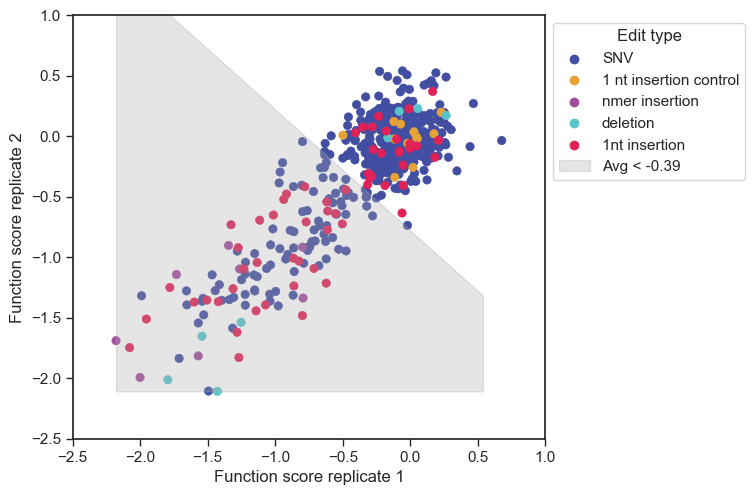

In [18]:
#Figure 1C - Interreplicate scores

sns.set_theme(rc={'figure.figsize':(6.1,5.5)})
sns.set_style("ticks")
ax=sns.scatterplot(data=df_final.sort_values('Type_expanded_further',key=np.vectorize(hue_order.index)), x="function_score_r1", y="function_score_r2",  hue="Type_expanded_further", palette=category_colors,
                   hue_order=hue_order,edgecolor=None)
# Define the shading condition
x_vals = np.linspace(df_final["function_score_r1"].min(), df_final["function_score_r2"].max(), 400)  # Generate x values for shading
y1 = -0.39 * 2 - x_vals  # y = -2x - 0.39 (average < -0.39)

# Shade the regions
plt.fill_between(x_vals, y1, df_final["function_score_r2"].min(), color='darkgrey', alpha=0.3, label="Avg < -0.39")

plt.xlim(-2.5, 1)
plt.ylim(-2.5, 1)
plt.ylabel("Function score replicate 2")
plt.xlabel("Function score replicate 1")
plt.legend(title='Edit type')
plt.tick_params(axis='both', which='both', length=5, width=1, direction='out')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("Fig_1_SGE_RNU4_2_interreplicate_scores_shading.pdf")

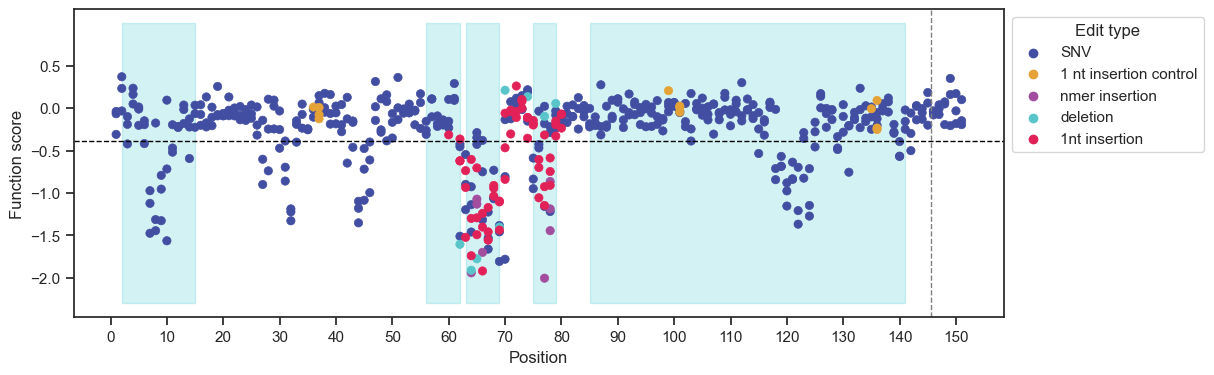

In [19]:
#Figure 1D - positional plot

sns.set_theme(rc={'figure.figsize':(12,4)})
sns.set_style("ticks")


# Add structure details
plt.fill_between([2,15], -2.3, 1, color='#27BEC7', alpha=0.2)
plt.fill_between([56,62], -2.3, 1, color='#27BEC7', alpha=0.2)
plt.fill_between([63,69], -2.3, 1, color='#27BEC7', alpha=0.2)
plt.fill_between([75,79], -2.3, 1, color='#27BEC7', alpha=0.2)
plt.fill_between([85,141], -2.3, 1, color='#27BEC7', alpha=0.2)

ax=sns.scatterplot(data=df_final.sort_values('Type_expanded_further',key=np.vectorize(hue_order.index)), x="position_oligonucleotide", y="function_score",  
                hue="Type_expanded_further", palette=category_colors,hue_order=hue_order,edgecolor=None)

ax.set_xticks(np.arange(int(df_final["position_oligonucleotide"].min()) - 1, int(df_final["position_oligonucleotide"].max()) + 1, 5))

# Add dashed horizontal line at y=-0.39 for q=0.01
ax.axhline(y=-0.39, color='black', linestyle='dashed', linewidth=1)  # Horizontal intercept

# Add dashed vertical lines at x=145.5 to mark end of transcript
ax.axvline(x=145.5, color='grey', linestyle='dashed', linewidth=1)  # Vertical intercept

plt.ylabel("Function score")
plt.xlabel("Position")
plt.legend(title='Edit type')

plt.xticks(np.arange(0,151,10))
plt.yticks(np.arange(-2,1,0.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig("Fig_1_SGE_RNU4_2_position_map.pdf")


In [20]:
#subset to SNVs for ROC_AUC analysis
df_merged=df_final[(df_final["category"]=='ReNU_syndrome')|(df_final["category"]=='UKBB/AllofUs')|(df_final["category"]=='unobserved')]
df_merged_SNV=df_merged[df_merged["Type"]=="SNV"]

/var/folders/0y/_jbdw0mj5bs1dbs_hr10k8wh0000gp/T/ipykernel_78306/873909841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_SNV["function_score"] = pd.to_numeric(df_merged_SNV["function_score"], errors="coerce")
/var/folders/0y/_jbdw0mj5bs1dbs_hr10k8wh0000gp/T/ipykernel_78306/873909841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_SNV["CADD_score"] = pd.to_numeric(df_merged_SNV["CADD_score"], errors="coerce")
/var/folders/0y/_jbdw0mj5bs1dbs_hr10k8wh0000gp/T/ipykernel_78306/87390

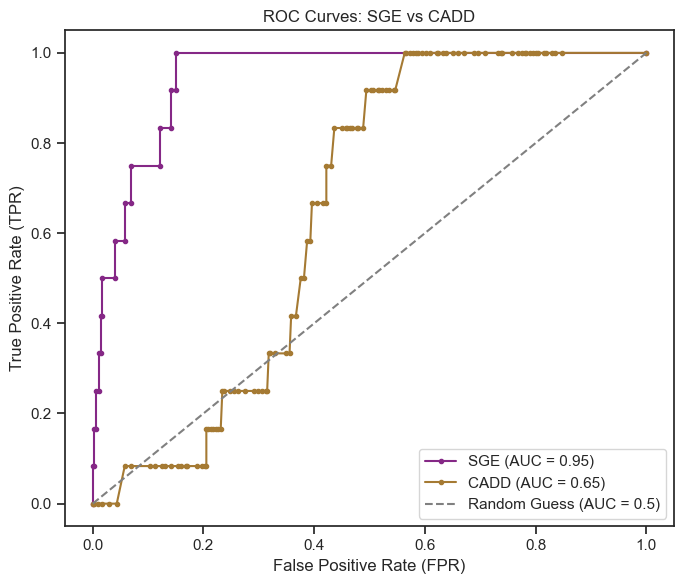

In [21]:
#Figure 2C - ROC-AUC curve

# Ensure scores are numeric
df_merged_SNV["function_score"] = pd.to_numeric(df_merged_SNV["function_score"], errors="coerce")
df_merged_SNV["CADD_score"] = pd.to_numeric(df_merged_SNV["CADD_score"], errors="coerce")

# Define labels: 1 = deleterious, 0 = neutral
df_merged_SNV["Label"] = np.where(
    df_merged_SNV["category"] == "ReNU_syndrome", 1,
    np.where(df_merged_SNV["category"] == "UKBB/AllofUs", 0, np.nan)
)

# Prepare for SGE ROC
df_sge = df_merged_SNV.dropna(subset=["Label", "function_score"]).copy()
df_sge["Label"] = df_sge["Label"].astype(int)
fpr_sge, tpr_sge, _ = roc_curve(df_sge["Label"], -df_sge["function_score"])  # Negate SGE
auc_sge = roc_auc_score(df_sge["Label"], -df_sge["function_score"])

# Prepare for CADD ROC
df_cadd = df_merged_SNV.dropna(subset=["Label", "CADD_score"]).copy()
df_cadd["Label"] = df_cadd["Label"].astype(int)
fpr_cadd, tpr_cadd, _ = roc_curve(df_cadd["Label"], df_cadd["CADD_score"])
auc_cadd = roc_auc_score(df_cadd["Label"], df_cadd["CADD_score"])

# Plot both curves
plt.figure(figsize=(7, 6))

plt.plot(fpr_sge, tpr_sge, label=f'SGE (AUC = {auc_sge:.2f})', color="#852886", marker='.')
plt.plot(fpr_cadd, tpr_cadd, label=f'CADD (AUC = {auc_cadd:.2f})', color="#A57A33", marker='.')

# Add diagonal line for random guess
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC = 0.5)')

# Labels and legend
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves: SGE vs CADD")
plt.legend()

# Save the combined ROC plot
plt.tight_layout()
plt.savefig("Fig2_combined_ROC_SGE_CADD.pdf", dpi=300)
plt.show()

/var/folders/0y/_jbdw0mj5bs1dbs_hr10k8wh0000gp/T/ipykernel_78306/2533721873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_SNV["AoU_AC"] = pd.to_numeric(df_merged_SNV["AoU_AC"], errors="coerce").fillna(0)
/var/folders/0y/_jbdw0mj5bs1dbs_hr10k8wh0000gp/T/ipykernel_78306/2533721873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_SNV["UKBiobank_AC"] = pd.to_numeric(df_merged_SNV["UKBiobank_AC"], errors="coerce").fillna(0)


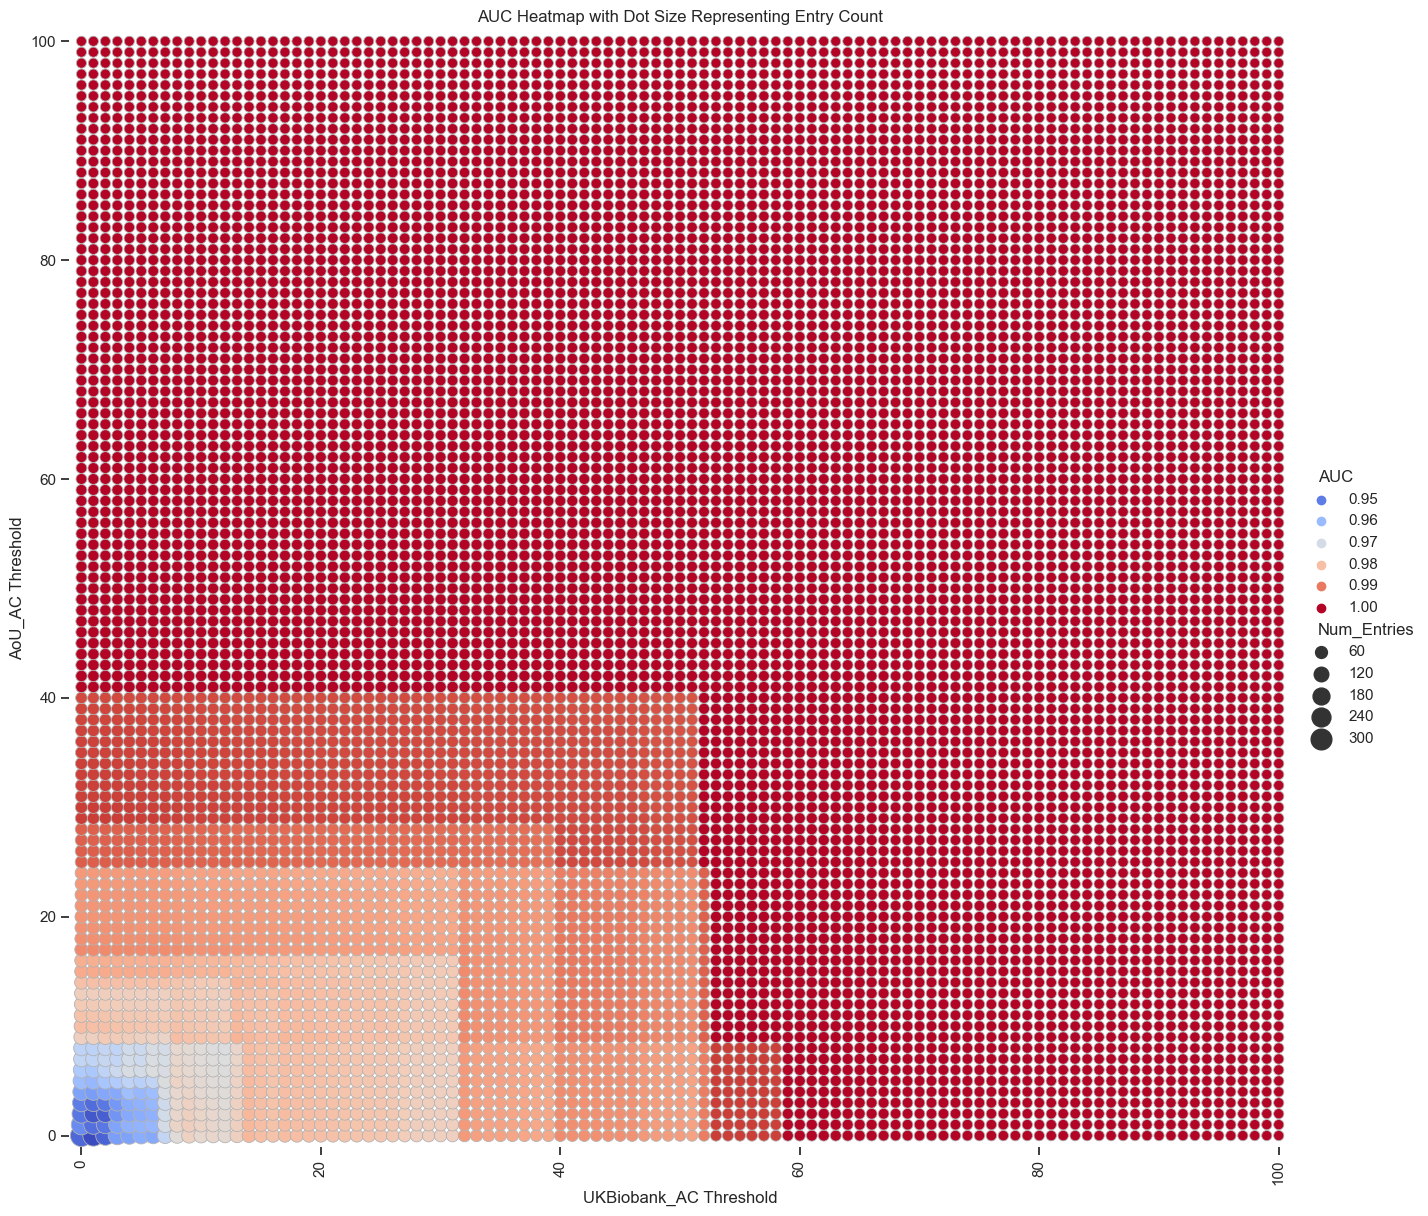

In [22]:
#Supplementary Figure 1 - Allele count parameter search for All of Us and UK biobank

# Convert AoU_AC and UKBiobank_AC to numeric, replacing NA with 0
df_merged_SNV["AoU_AC"] = pd.to_numeric(df_merged_SNV["AoU_AC"], errors="coerce").fillna(0)
df_merged_SNV["UKBiobank_AC"] = pd.to_numeric(df_merged_SNV["UKBiobank_AC"], errors="coerce").fillna(0)

# Define thresholds (increments of 1)
aou_thresholds = np.arange(0, 101, 1)
ukb_thresholds = np.arange(0, 101, 1)

# Create lists to store results
auc_results = []
num_entries = []

for aou_thresh in aou_thresholds:
    for ukb_thresh in ukb_thresholds:
        # Apply threshold filtering
        filtered_df = df_merged_SNV[
            ((df_merged_SNV["category"] == "ReNU_syndrome") |
             ((df_merged_SNV["category"] == "UKBB/AllofUs") &
              (df_merged_SNV["UKBiobank_AC"] >= ukb_thresh) &
              (df_merged_SNV["AoU_AC"] >= aou_thresh)))
        ].copy()  # <--- Explicitly create a copy to avoid the warning

        # Compute number of surviving entries
        num_entries.append((aou_thresh, ukb_thresh, len(filtered_df[filtered_df["category"]=='UKBB/AllofUs'])))

        if len(filtered_df) > 1:  # Ensure at least two samples to compute AUC
            # Assign labels: 1 for ReNU_syndrome, 0 for UKBB/AllofUs
            filtered_df.loc[:, "Label"] = np.where(filtered_df["category"] == "ReNU_syndrome", 1, 0)
            
            # Compute ROC AUC
            y_true = filtered_df["Label"]
            y_scores = -filtered_df["function_score"]
            auc_score = roc_auc_score(y_true, y_scores)
            auc_results.append((aou_thresh, ukb_thresh, auc_score))
        else:
            auc_results.append((aou_thresh, ukb_thresh, np.nan))  # Not enough data to compute AUC

# Convert results to DataFrame
auc_df = pd.DataFrame(auc_results, columns=["AoU_AC_Threshold", "UKBiobank_AC_Threshold", "AUC"])
num_df = pd.DataFrame(num_entries, columns=["AoU_AC_Threshold", "UKBiobank_AC_Threshold", "Num_Entries"])

# Merge the two DataFrames
merged_df = pd.merge(auc_df, num_df, on=["AoU_AC_Threshold", "UKBiobank_AC_Threshold"])

g = sns.relplot(
    data=merged_df,
    x="UKBiobank_AC_Threshold",
    y="AoU_AC_Threshold",
    hue="AUC",
    size="Num_Entries",
    palette="coolwarm",  # Diverging colormap for AUC
    #hue_norm=(0.5, 1.0),  # Normalize AUC values between 0.5 and 1.0 for visualization
    sizes=(50, 250),  # Adjust dot sizes based on entry count
    #size_norm=(merged_df["Num_Entries"].min(), merged_df["Num_Entries"].max()),
    edgecolor=".7",
    height=12,
    aspect=1.1
)

# Improve visualization settings
g.set(
    xlabel="UKBiobank_AC Threshold",
    ylabel="AoU_AC Threshold",
    title="AUC Heatmap with Dot Size Representing Entry Count"
)
g.despine(left=True, bottom=True)
g.ax.margins(0.02)

# Rotate X-axis labels for better readability
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

plt.xlim(-1,101)
plt.ylim(-1,101)
# Save the figure
plt.savefig("Sup_Fig2_AUC_Scatter_Heatmap_relplot.pdf", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
#min score per position calculation
df_snv_min_score = (
    df_merged_SNV[df_merged_SNV["Type_expanded_further"].str.contains("SNV", na=False)]
    .groupby("position_oligonucleotide", as_index=False)["function_score"]
    .min()
)
# Define the categorization based on function_score values
def categorize_function_score(score):
    if score < -1:
        return "high"
    elif -1 <= score < -0.39:
        return "moderate"
    else:
        return "neutral"
df_snv_min_score["category"] = df_snv_min_score["function_score"].apply(categorize_function_score)